<a href="https://colab.research.google.com/github/hoangcuongnguyen2001/Honours_Repository/blob/main/Fine_tune_SciBERT_for_CTI_analysis_from_TRAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SciBERT for Single-Label Classification

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/center-for-threat-informed-defense/tram/blob/main/user_notebooks/fine_tune_single_label.ipynb)

This notebook allows one to continue fine-tuning our provided SciBERT-for-singlelabel-sequence-classification on custom data.

In [ ]:
!mkdir scibert_single_label_model
!wget https://ctidtram.blob.core.windows.net/tram-models/single-label-202308303/config.json -O scibert_single_label_model/config.json
!wget https://ctidtram.blob.core.windows.net/tram-models/single-label-202308303/pytorch_model.bin -O scibert_single_label_model/pytorch_model.bin
!pip install torch transformers pandas

mkdir: cannot create directory ‘scibert_single_label_model’: File exists
--2023-09-26 04:09:33--  https://ctidtram.blob.core.windows.net/tram-models/single-label-202308303/config.json
Resolving ctidtram.blob.core.windows.net (ctidtram.blob.core.windows.net)... 52.239.246.4
Connecting to ctidtram.blob.core.windows.net (ctidtram.blob.core.windows.net)|52.239.246.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2806 (2.7K) [application/json]
Saving to: ‘scibert_single_label_model/config.json’

scibert_single_labe 100%[===================>]   2.74K  --.-KB/s    in 0s      

2023-09-26 04:09:33 (1.25 GB/s) - ‘scibert_single_label_model/config.json’ saved [2806/2806]

--2023-09-26 04:09:33--  https://ctidtram.blob.core.windows.net/tram-models/single-label-202308303/pytorch_model.bin
Resolving ctidtram.blob.core.windows.net (ctidtram.blob.core.windows.net)... 52.239.246.4
Connecting to ctidtram.blob.core.windows.net (ctidtram.blob.core.windows.net)|52.239.246.4|:443

This cell instantiates the label encoder. Do not modify this cell, as the classes (ie, ATT&CK techniques) and their order must match those the model expects.

In [ ]:
from sklearn.preprocessing import OneHotEncoder as OHE

CLASSES = [
   'T1003.001', 'T1005', 'T1012', 'T1016', 'T1021.001', 'T1027',
   'T1033', 'T1036.005', 'T1041', 'T1047', 'T1053.005', 'T1055',
   'T1056.001', 'T1057', 'T1059.003', 'T1068', 'T1070.004',
   'T1071.001', 'T1072', 'T1074.001', 'T1078', 'T1082', 'T1083',
   'T1090', 'T1095', 'T1105', 'T1106', 'T1110', 'T1112', 'T1113',
   'T1140', 'T1190', 'T1204.002', 'T1210', 'T1218.011', 'T1219',
   'T1484.001', 'T1518.001', 'T1543.003', 'T1547.001', 'T1548.002',
   'T1552.001', 'T1557.001', 'T1562.001', 'T1564.001', 'T1566.001',
   'T1569.002', 'T1570', 'T1573.001', 'T1574.002'
]

encoder = OHE(sparse_output=False)
encoder.fit([[c] for c in CLASSES])

encoder.categories_

[array(['T1003.001', 'T1005', 'T1012', 'T1016', 'T1021.001', 'T1027',
        'T1033', 'T1036.005', 'T1041', 'T1047', 'T1053.005', 'T1055',
        'T1056.001', 'T1057', 'T1059.003', 'T1068', 'T1070.004',
        'T1071.001', 'T1072', 'T1074.001', 'T1078', 'T1082', 'T1083',
        'T1090', 'T1095', 'T1105', 'T1106', 'T1110', 'T1112', 'T1113',
        'T1140', 'T1190', 'T1204.002', 'T1210', 'T1218.011', 'T1219',
        'T1484.001', 'T1518.001', 'T1543.003', 'T1547.001', 'T1548.002',
        'T1552.001', 'T1557.001', 'T1562.001', 'T1564.001', 'T1566.001',
        'T1569.002', 'T1570', 'T1573.001', 'T1574.002'], dtype=object)]

This cell is for loading the training data. You will need to modify this cell to load your data. Ensure that by the end of this cell, a DataFrame has been assigned to the variable `data` that has a `text` column containing the segments, and a `label` column containing individual strings, where those strings are an ATT&CK IDs that this model can classify. It does not matter how the DataFrame is indexed or what other columns with other names, if any, it has.

For demonstration purposes, we will use the same single-label data that was produced during this TRAM effort, even though the model was trained on this data already. This cell is only present to show the expected format of the `data` DataFrame, and is not intended to be run as shown.

In [ ]:
import pandas as pd
data = pd.read_json('single_label_1.json')
data

,text,label
0,TrickBot has used macros in Excel documents to...,T1059.003
1,SombRAT has the ability to use an embedded SOC...,T1090
2,Azorult can collect a list of running processe...,T1057
3,SeaDuke is capable of executing commands.,T1059.003
4,HOPLIGHT has the capability to harvest credent...,T1003.001
...,...,...
8838,"Wizard Spider has used ""ipconfig"" to identify ...",T1016
8839,StreamEx has the ability to enumerate drive ty...,T1083
8840,One persistence mechanism used by CozyCar is t...,T1547.001
8841,"To decode this information, BADNEWS takes the ...",T1140


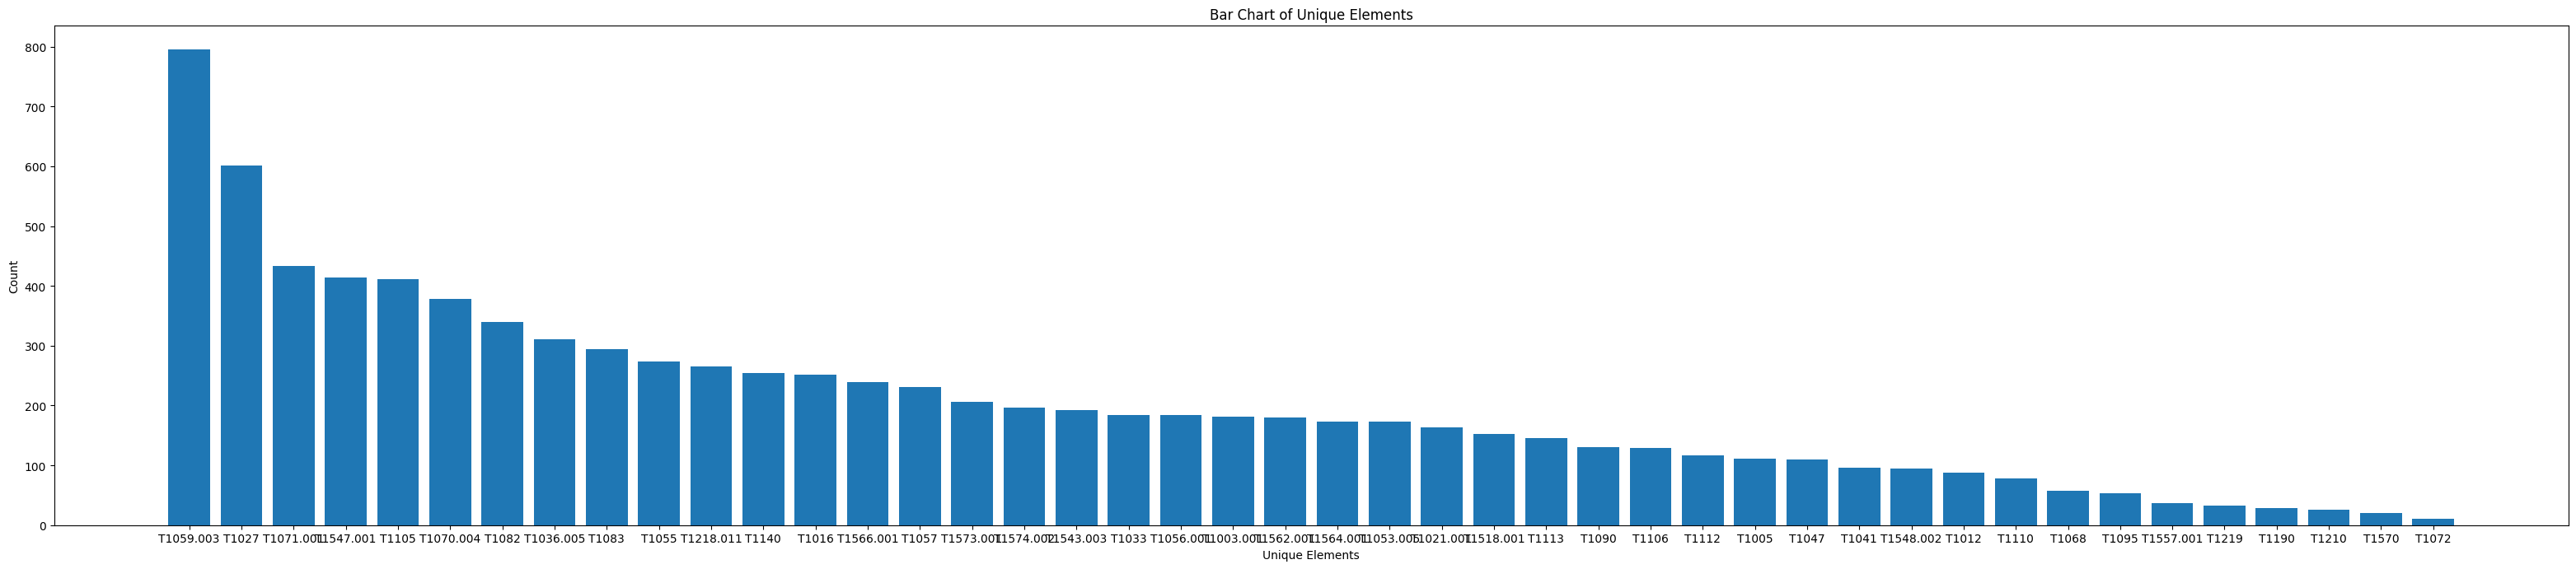

In [ ]:
import matplotlib.pyplot as plt

unique_elements = data['label'].value_counts()
unique_elements_list = unique_elements.reset_index().values.tolist()

def cm_to_inch(value):
    return value/2.54


plt.figure(figsize=(cm_to_inch(100), cm_to_inch(20)))
plt.bar(unique_elements.index, unique_elements.values)
plt.xlabel('Unique Elements')
plt.ylabel('Count')
plt.title('Bar Chart of Unique Elements')
plt.show()

In [ ]:
unique_elements_amount = unique_elements.reset_index().values
print(unique_elements_amount)

[['T1059.003' 795]
 ['T1027' 601]
 ['T1071.001' 433]
 ['T1547.001' 414]
 ['T1105' 411]
 ['T1070.004' 378]
 ['T1082' 340]
 ['T1036.005' 311]
 ['T1083' 294]
 ['T1055' 274]
 ['T1218.011' 265]
 ['T1140' 255]
 ['T1016' 251]
 ['T1566.001' 239]
 ['T1057' 231]
 ['T1573.001' 206]
 ['T1574.002' 197]
 ['T1543.003' 193]
 ['T1033' 184]
 ['T1056.001' 184]
 ['T1003.001' 181]
 ['T1562.001' 180]
 ['T1564.001' 173]
 ['T1053.005' 173]
 ['T1021.001' 164]
 ['T1518.001' 153]
 ['T1113' 145]
 ['T1090' 130]
 ['T1106' 129]
 ['T1112' 116]
 ['T1005' 111]
 ['T1047' 110]
 ['T1041' 96]
 ['T1548.002' 95]
 ['T1012' 88]
 ['T1110' 78]
 ['T1068' 58]
 ['T1095' 54]
 ['T1557.001' 37]
 ['T1219' 32]
 ['T1190' 28]
 ['T1210' 26]
 ['T1570' 20]
 ['T1072' 10]]


In [ ]:
import transformers
import torch

cuda = torch.device('cuda')

tokenizer = transformers.BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", max_length=512)
bert = transformers.BertForSequenceClassification.from_pretrained('scibert_single_label_model').to(cuda).train()

RuntimeError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, shuffle=True)

def _load_data(x, y, batch_size=10):
    x_len, y_len = x.shape[0], y.shape[0]
    assert x_len == y_len
    for i in range(0, x_len, batch_size):
        slc = slice(i, i + batch_size)
        yield x[slc].to(cuda), y[slc].to(cuda)

def _tokenize(instances: list[str]):
    return tokenizer(instances, return_tensors='pt', padding='max_length', truncation=True, max_length=512).input_ids

def _encode_labels(labels):
    """:labels: should be the `labels` column (a Series) of the DataFrame"""
    return torch.Tensor(encoder.transform(labels))

In [ ]:
x_train = _tokenize(train['text'].tolist())
x_train

NameError: ignored

In [ ]:
y_train = _encode_labels(train[['label']])
y_train

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

This array may appear to be empty, but taking the sum shows that there is one `1` per row.

In [ ]:
y_train.sum()

tensor(7074.)

This cell contains the training loop. You may change the `NUM_EPOCHS` value to any integer you would like.

In [ ]:
NUM_EPOCHS = 4

from statistics import mean

from tqdm import tqdm
from torch.optim import AdamW

optim = AdamW(bert.parameters(), lr=2e-5, eps=1e-8)

for epoch in range(NUM_EPOCHS):
    epoch_losses = []
    for x, y in tqdm(_load_data(x_train, y_train, batch_size=10)):
        bert.zero_grad()
        out = bert(x, attention_mask=x.ne(tokenizer.pad_token_id).to(int), labels=y)
        epoch_losses.append(out.loss.item())
        out.loss.backward()
        optim.step()
    print(f"epoch {epoch + 1} loss: {mean(epoch_losses)}")

708it [09:54,  1.19it/s]


epoch 1 loss: 0.02316723987631142


708it [09:56,  1.19it/s]


epoch 2 loss: 0.01402081927714743


708it [09:56,  1.19it/s]


epoch 3 loss: 0.009010586118237457


708it [09:56,  1.19it/s]

epoch 4 loss: 0.006306896385267156


If the loss from the last iteration was not to your liking, do not re-run the previous cell. Uncomment the following cell and run it for however many additional epochs you would like.

In [ ]:
# NUM_EXTRA_EPOCHS = 1
# for epoch in range(NUM_EXTRA_EPOCHS):
#     epoch_losses = []
#     for x, y in tqdm(_load_data(x_train, y_train, batch_size=10)):
#         bert.zero_grad()
#         out = bert(x, attention_mask=x.ne(tokenizer.pad_token_id).to(int), labels=y)
#         epoch_losses.append(out.loss.item())
#         out.loss.backward()
#         optim.step()
#     print(f"epoch {epoch + 1} loss: {mean(epoch_losses)}")

The next cells evaluate the performance after the additional fine-tuning. The
performance scores on the example data will be high, as the model has already been trained on most of these instances.

In [ ]:
bert.eval()

x_test = _tokenize(test['text'].tolist())
y_test = test['label']

batch_size = 20
preds = []

with torch.no_grad():
    for i in range(0, x_test.shape[0], batch_size):
        x = x_test[i : i + batch_size].to(cuda)
        out = bert(x, attention_mask=x.ne(tokenizer.pad_token_id).to(int))
        preds.extend(out.logits.to('cpu'))

import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support as calculate_score

predicted_labels = (
    encoder.inverse_transform(
        F.one_hot(
            torch.vstack(preds).softmax(-1).argmax(-1),
            num_classes=len(encoder.categories_[0])
        )
        .numpy()
    )
    .reshape(-1)
)

predicted = list(predicted_labels)
actual = y_test.tolist()

labels = sorted(set(actual) | set(predicted))

scores = calculate_score(actual, predicted, labels=labels)

scores_df = pd.DataFrame(scores).T
scores_df.columns = ['P', 'R', 'F1', '#']
scores_df.index = labels
scores_df.loc['(micro)'] = calculate_score(actual, predicted, average='micro', labels=labels)
scores_df.loc['(macro)'] = calculate_score(actual, predicted, average='macro', labels=labels)

scores_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,P,R,F1,#
T1003.001,0.765957,0.837209,0.800000,43.0
T1005,0.950000,0.703704,0.808511,27.0
T1012,0.900000,0.818182,0.857143,22.0
T1016,0.947368,0.981818,0.964286,55.0
T1021.001,0.850000,0.680000,0.755556,25.0
T1027,0.921053,0.963303,0.941704,109.0
T1033,0.974359,1.000000,0.987013,38.0
T1036.005,0.790323,0.875000,0.830508,56.0
T1041,0.833333,0.909091,0.869565,22.0
T1047,0.884615,0.920000,0.901961,25.0


In [ ]:
model = bert.save_pretrained("scibert_model")
tokenizer = tokenizer.save_pretrained("scibert_tokenizer")

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r scibert_model.zip scibert_model/
!zip -r scibert_tokenizer.zip scibert_tokenizer/

  adding: scibert_model/ (stored 0%)
  adding: scibert_model/pytorch_model.bin (deflated 7%)
  adding: scibert_model/config.json (deflated 69%)
  adding: scibert_tokenizer/ (stored 0%)
  adding: scibert_tokenizer/tokenizer_config.json (deflated 46%)
  adding: scibert_tokenizer/special_tokens_map.json (deflated 42%)
  adding: scibert_tokenizer/vocab.txt (deflated 52%)


In [ ]:
from google.colab import files
files.download('scibert_model.zip')
files.download('scibert_tokenizer.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>